In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from data_science_tools.datasets import AttrGeomSet
from data_science_tools.data_sources import BigQuery

%matplotlib inline

In [82]:
# Gather all the data
ds_input = AttrGeomSet.from_mnemonic("pj_living_area_dev_v5/20231115_cubicasa_ortho_survey_id_test")
df_input = ds_input.to_pandas()

df_inference = pd.read_hdf("/cnvrg/output/inference/output_tensors.h5")
df_input = df_input.merge(df_inference, on=["geometry", "imagery_source", "imagery_date"])

In [84]:
big_query = BigQuery()

# Get all relevant cape features for the inference set
query = """--sql
    SELECT j.attom_id,
           j.cc_ticket_id,
           book.prod_roof_covering,
           book.prod_roof_geometry,
           book.prod_chimney_presence,
           book.prod_structure_style,
           book.prod_number_of_stories,
           book.prod_wood_deck_presence
    FROM `ml-dev-a7b7.cubicasa_gold.cubi_sfh_junction` AS j
    JOIN `ml-dev-a7b7.cubicasa_gold.prod_cape_bookrun` AS book
    ON j.cape_full_address = book.cape_full_address
    WHERE j.data_destination = 'test'
"""
df_features = big_query.get_data(query=query).to_dataframe()

In [85]:
df = df_input.merge(df_features, on=["attom_id", "cc_ticket_id"], how="inner")

In [86]:
# collect embeddings columns
embedding_columns = [col for col in df.columns if col.startswith("emb")]

# gather as numpy array
embeddings = df[embedding_columns].to_numpy()

In [87]:
# PCA decomposition
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

<AxesSubplot: >

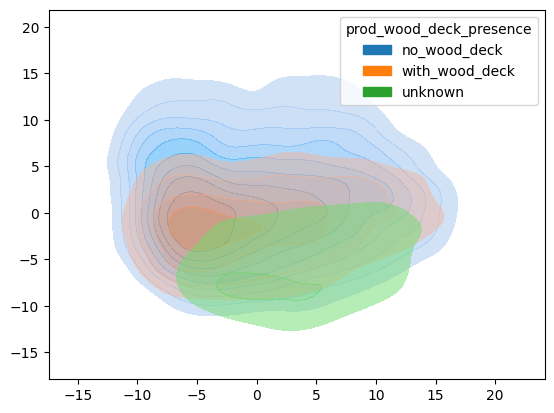

In [88]:
sns.kdeplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=df["prod_wood_deck_presence"], fill=True, alpha=0.5)

In [102]:
target = "prod_chimney_presence"

In [103]:
# split dataframe into train and test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x_train = df_train[embedding_columns].to_numpy()
x_test = df_test[embedding_columns].to_numpy()

y_train = df_train[target].to_numpy()
y_test = df_test[target].to_numpy()

0.702755905511811
0.6078836163156202
0.6809752303096883
0.5780957406745898


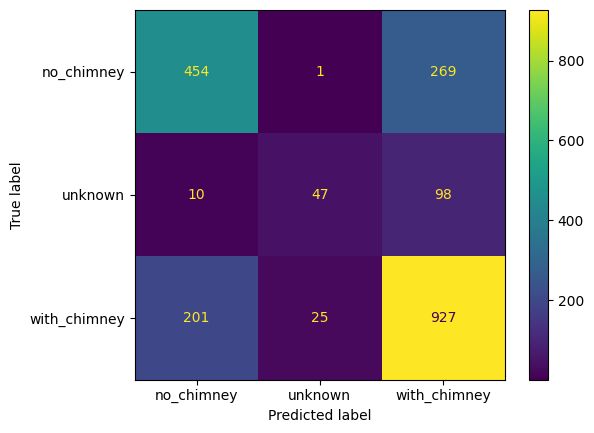

In [104]:
# Simple sklearn classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced", n_jobs=-1)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [97]:
len(x_test)

2032